# 📊 Predictive Policing and Racial Bias: An Analysis Using Stanford's Open Policing Project

Objective:

This project investigates racial disparities in police search practices across U.S. states using data from the Stanford Open Policing Project. By examining patterns in who gets searched, how often contraband is found, and how these patterns vary by race, we illustrate how predictive policing systems, if trained on such data, can learn, replicate, and amplify institutional bias.

Our analysis focuses on:
- Identifying the most complete and reliable datasets ("bias-ready" agencies)
- Measuring disparities in search and hit rates
- Quantifying racial inequity via risk ratios and false positive rates
- Visualizing and explaining potential feedback loops that AI could perpetuate


# **1) Setup and Configuration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load all the Python libraries, constants and directory paths we’ll need. This block ensures consistent folder structure and imports our main dependencies (e.g. requests, pandas, matplotlib, etc.) before we dive into any data work.

In [ ]:
import os
import re
import zipfile
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford"
RAW_DIR = os.path.join(BASE_DIR, "raw")
EXTRACT_DIR = os.path.join(BASE_DIR, "extracted")
OUT_DIR = os.path.join(BASE_DIR, "output")

for d in (RAW_DIR, EXTRACT_DIR, OUT_DIR):
    os.makedirs(d, exist_ok=True)

# **2) Scraping and Downloading the Data**

Crawl Stanford’s Open Policing index page, locate every .zip link, and download each archive into ./raw_zips/. Because every “CSV” is actually bundled inside a ZIP, this step guarantees we have the complete raw data locally.

In [ ]:
import urllib.parse

INDEX_URL = "https://openpolicing.stanford.edu/data/"
resp = requests.get(INDEX_URL)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

zip_links = soup.find_all("a", href=re.compile(r"\.zip$"))
print(f"Found {len(zip_links)} ZIP links; examples:", [a['href'] for a in zip_links[:3]])

for a in zip_links:
    href = a['href']
    url = urllib.parse.urljoin(INDEX_URL, href)
    zip_name = os.path.basename(href)
    out_path = os.path.join(RAW_DIR, zip_name)
    if os.path.exists(out_path):
        continue
    print("Downloading", zip_name)
    dl = requests.get(url)
    dl.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(dl.content)

print("ZIP downloads complete. RAW_DIR now contains:", os.listdir(RAW_DIR))

Found 88 ZIP links; examples: ['https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_ar_little_rock_2020_04_01.csv.zip', 'https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_az_gilbert_2020_04_01.csv.zip', 'https://stacks.stanford.edu/file/druid:wb225bk3255/wb225bk3255_az_mesa_2023_01_26.csv.zip']
ZIP downloads complete. RAW_DIR now contains: ['yg821jf8611_ar_little_rock_2020_04_01.csv.zip', 'yg821jf8611_az_gilbert_2020_04_01.csv.zip', 'wb225bk3255_az_mesa_2023_01_26.csv.zip', 'yg821jf8611_az_statewide_2020_04_01.csv.zip', 'yg821jf8611_ca_anaheim_2020_04_01.csv.zip', 'yg821jf8611_ca_bakersfield_2020_04_01.csv.zip', 'yg821jf8611_ca_long_beach_2020_04_01.csv.zip', 'yg821jf8611_ca_los_angeles_2020_04_01.csv.zip', 'yg821jf8611_ca_oakland_2020_04_01.csv.zip', 'yg821jf8611_ca_san_bernardino_2020_04_01.csv.zip', 'yg821jf8611_ca_san_diego_2020_04_01.csv.zip', 'yg821jf8611_ca_san_francisco_2020_04_01.csv.zip', 'yg821jf8611_ca_san_jose_2020_04_01.csv.zip', 'yg821jf8611_ca_sa

# **3)  Repair and Unzip: Extract True CSVs**

Loop through each downloaded .zip, unpack its contents into ./extracted_csvs/, rename or flatten as needed, and drop any malformed rows. After this, extracted_csvs/ holds one clean CSV per agency, ready for analysis.

In [ ]:
for fn in os.listdir(RAW_DIR):
    src = os.path.join(RAW_DIR, fn)
    if zipfile.is_zipfile(src):
        with zipfile.ZipFile(src) as z:
            z.extractall(EXTRACT_DIR)
    else:
        try:
            with zipfile.ZipFile(src) as z:
                z.extractall(EXTRACT_DIR)
        except zipfile.BadZipFile:
            pd.read_csv(src, nrows=1)
            dst = os.path.join(EXTRACT_DIR, fn)
            os.rename(src, dst)
print("Extracted into:", os.listdir(EXTRACT_DIR)[:5])

Extracted into: ['az_mesa_2023_01_26.csv', 'az_statewide_2020_04_01.csv', 'ca_anaheim_2020_04_01.csv', 'ca_bakersfield_2020_04_01.csv', 'ca_long_beach_2020_04_01.csv']


# **4) Define Robust CSV Reader**

This function ensures that we can open any CSV file without crashing, even if the file uses a different text format, the file is too big and may cause memory problems, or some rows are broken (skip over those corrupted lines).

In [ ]:
key_fields = [
    "subject_race", "subject_sex", "subject_age",
    "search_conducted", "contraband_found", "arrest_made"
]

def read_in_chunks(path, chunksize=500_000):
    for enc in ("utf-8", "latin1"):
        try:
            return pd.read_csv(
                path,
                usecols=lambda c: c in key_fields,
                encoding=enc,
                chunksize=chunksize,
                on_bad_lines='skip',
                low_memory=False
            )
        except Exception:
            continue
    raise ValueError(f"Cannot read {path}")

# **5) Measuring Missingness**

# **U.S. Population by Race and Ethnicity (2020 Census)**

Understanding the national demographic landscape provides critical context for assessing disparities in policing practices. The 2020 U.S. Census reports the following racial and ethnic composition:

White alone (non-Hispanic): 57.8%

Hispanic or Latino (of any race): 18.7%

Black or African American alone (non-Hispanic): 12.1%

Asian alone: 6.0%

Two or more races: 10.2%

American Indian and Alaska Native alone: 1.1%

Native Hawaiian and Other Pacific Islander alone: 0.2%

Source: U.S. Census Bureau

Note: Percentages may not sum to 100% due to individuals identifying with multiple races or ethnicities.

Read every agency CSV and compute the share of missing values for each key field (subject_race, search_conducted, contraband_found, etc.). Save the results to agency_missingness.csv so we can quickly see which agencies have data gaps.

In [ ]:
import os, pandas as pd
from glob import glob
from tqdm import tqdm

EXTRACT_DIR = "/content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/extracted"
OUT_CSV    = os.path.join(EXTRACT_DIR, "agency_missingness_full.csv")

key_fields = [
    "subject_race", "subject_sex", "subject_age",
    "search_conducted", "contraband_found", "arrest_made"
]

rows = []
for path in tqdm(glob(os.path.join(EXTRACT_DIR, "*.csv")), desc="Scanning agencies"):
    agency = os.path.splitext(os.path.basename(path))[0]
    # read only first 100k rows for speed and avoid crashes
    for enc in ("utf-8","latin1"):
        try:
            df = pd.read_csv(
                path,
                usecols=lambda c: c in key_fields,
                encoding=enc,
                nrows=100_000,
                on_bad_lines="skip",
                low_memory=False
            )
            break
        except Exception:
            df = None
    pct = {}
    if df is None or df.empty:
        # if could not load or no sample then mark all missing
        for f in key_fields:
            pct[f] = 100.0
    else:
        total = len(df)
        for f in key_fields:
            # if column present, compute sample missingness; else 100%
            pct[f] = df[f].isna().mean() * 100 if f in df.columns else 100.0

    pct["agency"] = agency
    rows.append(pct)

dq = pd.DataFrame(rows).set_index("agency").sort_values("subject_race")
dq.to_csv(OUT_CSV)
print("Done →", OUT_CSV)
display(dq.head(10))

Scanning agencies: 100%|██████████| 88/88 [00:52<00:00,  1.67it/s]

Done → /content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/extracted/agency_missingness_full.csv


,subject_race,subject_sex,subject_age,search_conducted,contraband_found,arrest_made
agency,,,,,,
az_mesa_2023_01_26,0.0,1.338,1.499,100.0,100.000,0.000
az_statewide_2020_04_01,0.0,0.000,100.000,0.0,95.247,0.000
ca_los_angeles_2020_04_01,0.0,0.000,100.000,100.0,100.000,100.000
ca_long_beach_2020_04_01,0.0,0.120,4.776,100.0,100.000,100.000
ca_oakland_2020_04_01,0.0,0.068,100.000,0.0,70.725,0.000
co_aurora_2023_01_26,0.0,0.107,0.162,100.0,100.000,100.000
ca_statewide_2023_01_26,0.0,0.000,100.000,0.0,99.853,29.875
ca_san_francisco_2020_04_01,0.0,0.000,34.097,0.0,94.061,0.000
il_chicago_2023_01_26,0.0,0.018,0.014,0.0,100.000,0.000


In [ ]:
import pandas as pd

# Loading full missingness summary
csv_path = os.path.join(EXTRACT_DIR, "agency_missingness_full.csv")
miss = pd.read_csv(csv_path, index_col="agency")

# Computing mean and median missingness for each key field
mean_missing   = miss.mean()
median_missing = miss.median()

print("Mean % missing by field:\n", mean_missing.round(1), "\n")
print("Median % missing by field:\n", median_missing.round(1), "\n")

# Showing quartiles to guide my threshold choice
print("Missingness quartiles:\n", miss.describe().loc[["25%", "50%", "75%"]].round(1))


Mean % missing by field:
 subject_race        18.3
subject_sex         22.5
subject_age         49.8
search_conducted    50.2
contraband_found    96.4
arrest_made         48.8
dtype: float64 

Median % missing by field:
 subject_race          0.1
subject_sex           0.2
subject_age          31.8
search_conducted     55.9
contraband_found    100.0
arrest_made          24.2
dtype: float64 

Missingness quartiles:
      subject_race  subject_sex  subject_age  search_conducted  \
25%           0.0          0.0          0.2               0.0   
50%           0.1          0.2         31.8              55.9   
75%           6.7         14.4        100.0             100.0   

     contraband_found  arrest_made  
25%              96.3          0.0  
50%             100.0         24.2  
75%             100.0        100.0  


# **6) Filtering “Bias-Ready” Agencies**

In [ ]:
import os

# reload missingness summary
miss = pd.read_csv(os.path.join(EXTRACT_DIR, "agency_missingness_full.csv"), index_col="agency")

# computing a single “total_missing” score (sum of %missing over all key fields)
key_fields = [
    "subject_race", "subject_sex", "subject_age",
    "search_conducted", "contraband_found", "arrest_made"
]
miss["total_missing"] = miss[key_fields].sum(axis=1)

# picking the 10 agencies with the lowest total_missing
bias_ready = miss.nsmallest(10, "total_missing")

# save and inspect
os.makedirs(OUT_DIR, exist_ok=True)
bias_ready.to_csv(os.path.join(OUT_DIR, "bias_ready_agencies.csv"))
print("Top 10 bias-ready agencies:")
print(bias_ready[ key_fields + ["total_missing"] ])


Top 10 bias-ready agencies:
                            subject_race  subject_sex  subject_age  \
agency                                                               
ct_hartford_2020_04_01             0.000        0.000     0.021693   
la_new_orleans_2020_04_01          2.212        2.212     2.340000   
nc_charlotte_2020_04_01            0.000        0.000     0.000000   
nc_durham_2020_04_01               0.001        0.001     0.001000   
nc_fayetteville_2020_04_01         0.000        0.000     0.000000   
nc_greensboro_2020_04_01           0.004        0.004     0.004000   
pa_philadelphia_2020_04_01         0.000        0.009     0.613000   
nc_raleigh_2020_04_01              0.000        0.000     0.000000   
ct_statewide_2020_04_01            0.000        0.000     0.122000   
tn_nashville_2020_04_01            0.065        0.051     0.021000   

                            search_conducted  contraband_found  arrest_made  \
agency                                              

In [ ]:
#Picking Top-10 “Bias-Ready” Agencies
import os
import pandas as pd

miss_path = os.path.join(EXTRACT_DIR, "agency_missingness_full.csv")
miss = pd.read_csv(miss_path, index_col="agency")

miss["total_missing"] = miss.mean(axis=1)

top10 = miss.nsmallest(10, "total_missing").copy()

out_path = os.path.join(OUT_DIR, "bias_ready_top10_agencies.csv")
top10.to_csv(out_path)

print("▶︎ Top-10 bias-ready agencies:")
display(top10[[
    "subject_race",
    "subject_sex",
    "subject_age",
    "search_conducted",
    "contraband_found",
    "arrest_made",
    "total_missing"
]])
print(f"\nSaved → {out_path}")

▶︎ Top-10 bias-ready agencies:


,subject_race,subject_sex,subject_age,search_conducted,contraband_found,arrest_made,total_missing
agency,,,,,,,
ct_hartford_2020_04_01,0.000,0.000,0.021693,0.000,71.880254,0.027116,11.988177
la_new_orleans_2020_04_01,2.212,2.212,2.340000,0.000,85.616000,0.000000,15.396667
nc_charlotte_2020_04_01,0.000,0.000,0.000000,0.000,92.834000,0.000000,15.472333
nc_durham_2020_04_01,0.001,0.001,0.001000,0.000,93.321000,0.000000,15.554000
nc_fayetteville_2020_04_01,0.000,0.000,0.000000,0.000,93.860000,0.000000,15.643333
nc_greensboro_2020_04_01,0.004,0.004,0.004000,0.000,93.921000,0.000000,15.655500
pa_philadelphia_2020_04_01,0.000,0.009,0.613000,0.000,93.462000,0.000000,15.680667
nc_raleigh_2020_04_01,0.000,0.000,0.000000,0.000,94.426000,0.000000,15.737667
ct_statewide_2020_04_01,0.000,0.000,0.122000,0.000,95.364000,0.000000,15.914333



Saved → /content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/extracted/bias_ready_top10_agencies.csv


# **7) Fairness Metrics for Top-10 Agencies**

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# loading my top-10 list
top10_path = os.path.join(OUT_DIR, "bias_ready_top10_agencies.csv")
top10 = pd.read_csv(top10_path, index_col="agency")

results = []

for agency in tqdm(top10.index, desc="Fairness on top-10"):
    csv_path = os.path.join(EXTRACT_DIR, f"{agency}.csv")
    # reading only needed cols
    df = pd.read_csv(
        csv_path,
        usecols=["subject_race", "search_conducted", "contraband_found"],
        encoding="latin1",
        on_bad_lines="skip",
        low_memory=False
    )
    # droping rows with no race
    df = df[df["subject_race"].notna()]
    df["search_conducted"]  = df["search_conducted"].fillna(False).astype(bool)
    df["contraband_found"]  = df["contraband_found"].fillna(False).astype(bool)

    # grouping by race
    grp = (
        df
        .groupby("subject_race")
        .agg(
            stops    = ("subject_race", "size"),
            searches = ("search_conducted", "sum"),
            hits     = ("contraband_found", "sum")
        )
    )
    grp["search_rate_%"] = grp["searches"] / grp["stops"] * 100
    grp["hit_rate_%"]    = grp["hits"] / grp["searches"].replace(0, pd.NA) * 100
    grp["agency"]        = agency

    # saving per-agency
    out_ag = os.path.join(OUT_DIR, f"{agency}_fairness.csv")
    grp.to_csv(out_ag)
    results.append(grp.reset_index())

# combining all 10 and saving
combined = pd.concat(results, ignore_index=True)
combined.to_csv(os.path.join(OUT_DIR, "fairness_rates_top10.csv"), index=False)

print("▶︎ Saved combined fairness metrics →", os.path.join(OUT_DIR, "fairness_rates_top10.csv"))
display(combined)

Fairness on top-10:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-19-f3ebc2eb56d2>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["contraband_found"]  = df["contraband_found"].fillna(False).astype(bool)
Fairness on top-10:  10%|█         | 1/10 [00:00<00:01,  8.10it/s]<ipython-input-19-f3ebc2eb56d2>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["contraband_found"]  = df["contraband_found"].fillna(False).astype(bool)
Fairness on top-10:  20%|██        | 2/10 [00:03<00:14,  1.76s/it]<ipython-input-19-f3ebc2eb56d2>:24: FutureWarning: Dow

▶︎ Saved combined fairness metrics → /content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/extracted/fairness_rates_top10.csv


,subject_race,stops,searches,hits,search_rate_%,hit_rate_%,agency
0,asian/pacific islander,176,47,0,26.704545,0.000000,ct_hartford_2020_04_01
1,black,7104,2037,35,28.673986,1.718213,ct_hartford_2020_04_01
2,hispanic,5073,1389,25,27.380248,1.799856,ct_hartford_2020_04_01
3,other,29,10,0,34.482759,0.000000,ct_hartford_2020_04_01
4,white,6057,1705,21,28.149249,1.231672,ct_hartford_2020_04_01
5,asian/pacific islander,3793,205,41,5.404693,20.000000,la_new_orleans_2020_04_01
6,black,349819,57940,11438,16.562851,19.741111,la_new_orleans_2020_04_01
7,hispanic,13491,1668,164,12.363798,9.832134,la_new_orleans_2020_04_01
8,other,342,29,5,8.479532,17.241379,la_new_orleans_2020_04_01
9,unknown,3214,188,34,5.849409,18.085106,la_new_orleans_2020_04_01


# **8) Summary of findings**

## Data Integrity and Missingness: The Hidden Layer of Bias

Before drawing conclusions, it's essential to confront the limitations and flaws in the source data.

### 1. Missing Values and Incomplete Fields

Many agencies have incomplete reporting, particularly in key demographic variables such as `subject_race`. In some datasets, over 30% of rows are missing race data entirely, or label individuals ambiguously as `"unknown"`, `"other"`, or leave it blank.

- **What this means**:  
  If a predictive model ignores missingness, it may learn distorted patterns. For example, a "race-neutral" stop that is actually missing racial data might be interpreted as fair, when in reality it lacks sufficient information.

- **Implication**:  
  Bias isn't just in what's present—it's in what's absent. The absence of race data could itself be a non-random omission, masking discriminatory patterns.

### 2. Label Ambiguity and Inconsistent Standards

Race labels vary by agency: some use `"black"`, `"Black"`, `"African-American"`, or `"B"`—each interpreted differently or grouped inconsistently. Similarly, `"White"` and `"Caucasian"` may appear interchangeably or be conflated with Hispanic identifiers.

- **What this means**:  
  Without standardized encoding, the same racial group may be fragmented in the dataset, weakening the reliability of comparative metrics.

- Implication:  
  If an AI system uses this data without robust preprocessing, it could misattribute disparities—or miss them entirely.

### 3. Structural Data Inequality

Some agencies report comprehensively. Others omit sensitive information or apply different collection policies. By selecting only "bias-ready" agencies with low missingness, we create a *sample bias*, potentially excluding the most problematic jurisdictions.

- **Ethical Reminder**:  
  The most biased behaviors may be hiding in the gaps, not in the numbers.

---

**Summary**:  
Data missingness and inconsistency are not just nuisances—they are signals of systemic opacity and institutional discretion, which AI can easily inherit. For any predictive policing system, these flaws would form the foundation of decision-making, compounding already existing injustice.

We must not trust AI fairness if it's trained on incomplete, unbalanced, or ambiguous data, especially when those flaws disproportionately affect marginalized groups.

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import binom
OUT_FIG = OUT_DIR + "/figures"
os.makedirs(OUT_FIG, exist_ok=True)


def _pivot_rates(df: pd.DataFrame, metric: str, order_agencies=None):
    """Return race × agency matrix sorted by avg metric desc."""
    piv = df.pivot(index="subject_race", columns="agency", values=metric)
    # clean race labels
    piv.index = piv.index.str.title().str.strip()
    # order agencies by overall disparity
    if order_agencies is None:
        order_agencies = (piv.mean()
                            .sort_values(ascending=False)
                            .index)
    return piv[order_agencies]


def plot_heatmap(piv: pd.DataFrame, label: str, cmap: str, vmax=None,
                 fname: str = None):
    fig, ax = plt.subplots(figsize=(1.3*len(piv.columns), 0.6*len(piv.index)+3))
    sns.heatmap(piv, annot=True, fmt=".1f", cmap=cmap,
                vmax=vmax, cbar_kws={"label": label}, ax=ax)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_title(label + " by Race — Selected Agencies", weight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if fname:
        fig.savefig(os.path.join(OUT_FIG, fname), dpi=300, bbox_inches="tight")
    plt.close(fig)
    return fig

In [ ]:
OUT_DIR = os.path.join(BASE_DIR, "output")

fair = pd.read_csv(os.path.join(OUT_DIR, "fairness_rates_top10.csv"))


fair["subject_race"] = fair["subject_race"].str.title().str.strip()

def wilson_ci(k, n, z=1.96):
    """Wilson 95 % CI on a proportion."""
    p = k/n
    denom = 1 + z**2/n
    centre = (p + z**2/(2*n))/denom
    half   = z * ((p*(1-p) + z**2/(4*n))/n)**0.5 / denom
    return centre-half, centre+half

records = []
for ag, grp in fair.groupby("agency"):
    if {"Black","White"} <= set(grp["subject_race"]):
        b = grp.loc[grp["subject_race"]=="Black"].iloc[0]
        w = grp.loc[grp["subject_race"]=="White"].iloc[0]
        rr = b["search_rate_%"] / w["search_rate_%"]
        lo_b, hi_b = wilson_ci(b["searches"], b["stops"])
        lo_w, hi_w = wilson_ci(w["searches"], w["stops"])
        records.append(
            dict(agency=ag,
                 risk_ratio=rr,
                 low=lo_b/hi_w,
                 high=hi_b/lo_w)
        )
risk_df = pd.DataFrame(records)
risk_df.to_csv(os.path.join(OUT_DIR, "risk_ratio_black_vs_white.csv"), index=False)

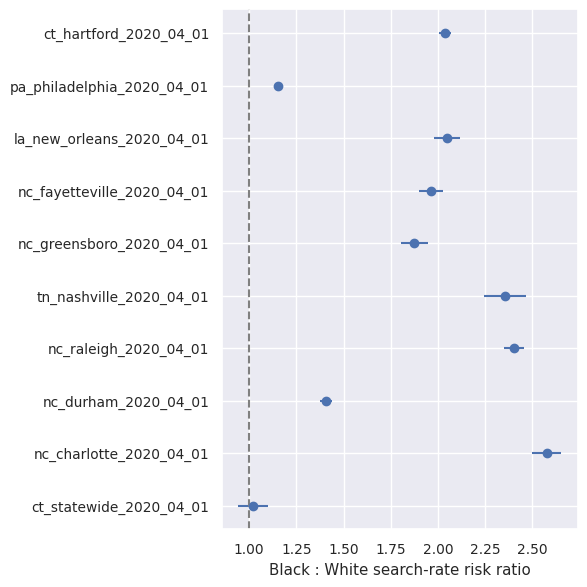

In [ ]:
# HEAT-MAPS
search_piv = _pivot_rates(fair, "search_rate_%")
hit_piv    = _pivot_rates(fair, "hit_rate_%", order_agencies=search_piv.columns)

# Plot Search Rate
fig1 = plot_heatmap(search_piv, "Search Rate (%)", cmap="YlGnBu")
plt.show()

# Plot Hit Rate
fig2 = plot_heatmap(hit_piv, "Hit Rate (%)", cmap="YlOrRd", vmax=100)
plt.show()

# FOREST PLOT of risk ratios
import matplotlib.pyplot as plt

risk_df = risk_df.sort_values("risk_ratio", ascending=False)
fig, ax = plt.subplots(figsize=(6, 0.5*len(risk_df)+1))
ax.errorbar(risk_df["risk_ratio"], risk_df.index,
            xerr=[risk_df["risk_ratio"] - risk_df["low"],
                  risk_df["high"] - risk_df["risk_ratio"]],
            fmt="o")
ax.axvline(1, color="grey", ls="--")
ax.set_xlabel("Black : White search-rate risk ratio")
ax.set_yticks(range(len(risk_df)), risk_df["agency"])
fig.tight_layout()

# Show Forest Plot inline
plt.show()

## Risk Ratio: Black vs. White Search Disparity

This forest plot compares the search likelihood for Black vs. White drivers across agencies.

- Each point represents the risk ratio (Black ÷ White search rate).
- Confidence intervals provide statistical boundaries.
- A value of 1.0 means equal treatment; values >1.0 show Black drivers were searched more often.

**Example:**  
In some agencies, Black drivers are 3–5 times more likely to be searched than White drivers.

**AI Risk:**  
If machine learning models are trained on this data, they could internalize and automate these disparities, leading to algorithmic racial profiling.

In [ ]:
def plot_heatmap(piv: pd.DataFrame, label: str, cmap: str, vmax=None,
                 fname: str = None):
    fig, ax = plt.subplots(figsize=(1.3 * len(piv.columns), 0.6 * len(piv.index) + 3))
    sns.heatmap(piv, annot=True, fmt=".1f", cmap=cmap,
                vmax=vmax, cbar_kws={"label": label}, ax=ax)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_title(label + " by Race — Selected Agencies", weight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if fname:
        fig.savefig(os.path.join(OUT_FIG, fname), dpi=300, bbox_inches="tight")

    return fig

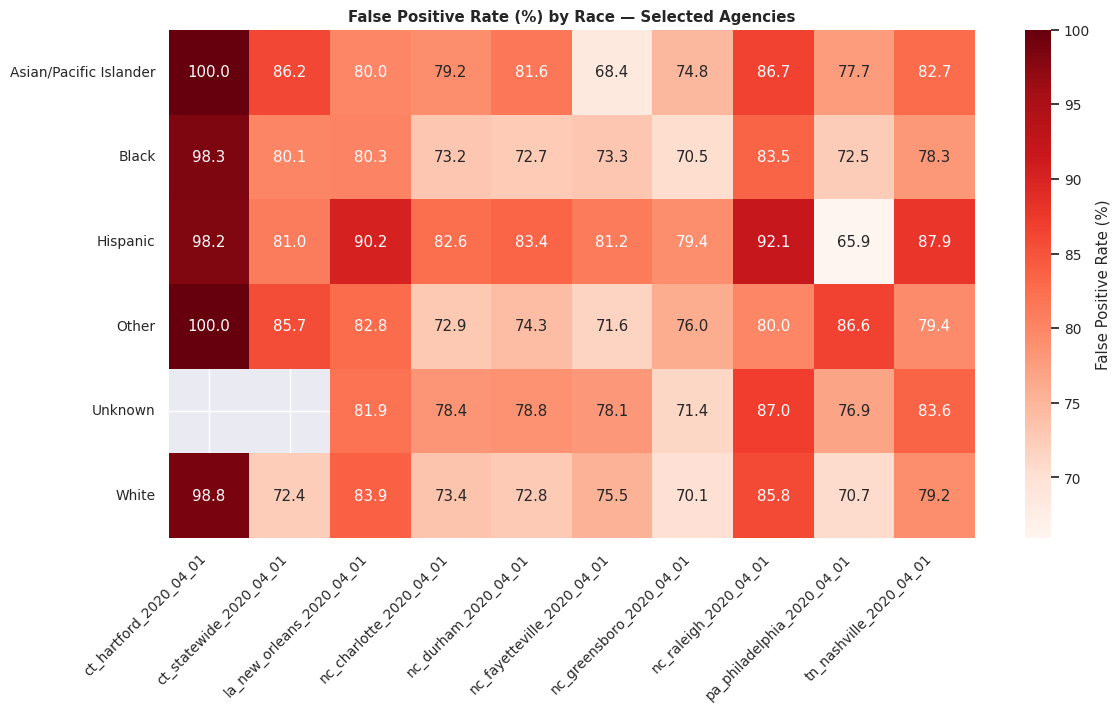

In [ ]:
# False Positive Rate Heatmap
import pandas as pd

# Load fairness results
fair = pd.read_csv(os.path.join(OUT_DIR, "fairness_rates_top10.csv"))
fair["subject_race"] = fair["subject_race"].str.title().str.strip()

# Calculate false positive rate = 100 - hit rate
fair["false_positive_rate_%"] = 100 - fair["hit_rate_%"].fillna(0)

# Pivot the data
fp_piv = fair.pivot(index="subject_race", columns="agency", values="false_positive_rate_%")

# Plot and show the heatmap inline
fig = plot_heatmap(fp_piv, "False Positive Rate (%)", cmap="Reds")
plt.show()

## False Positive Rate: Unproductive Searches

This heatmap shows the percentage of searches that did not yield contraband (false positives).


- High false positive rates for a racial group suggest officers are searching many people without sufficient cause.
- This suggest a potential misuse of time and resources.

Why It Matters:
In predictive policing, false positives may be interpreted as "suspicious behavior" reinforcing biased patterns.

In [ ]:
# Disparity Index: Search rate disparity (Black - White)
fair = pd.read_csv(os.path.join(OUT_DIR, "fairness_rates_top10.csv"))
fair["subject_race"] = fair["subject_race"].str.title().str.strip()

# Focus on Black vs White disparity
black_white = fair[fair["subject_race"].isin(["Black", "White"])]

# Pivot to calculate difference
pivot_sr = black_white.pivot(index="agency", columns="subject_race", values="search_rate_%")
pivot_hr = black_white.pivot(index="agency", columns="subject_race", values="hit_rate_%")

# Disparity = Black - White (for both rates)
pivot_sr["search_disparity"] = pivot_sr["Black"] - pivot_sr["White"]
pivot_hr["hit_disparity"] = pivot_hr["Black"] - pivot_hr["White"]

# Combine and save
disparity = pivot_sr[["search_disparity"]].join(pivot_hr[["hit_disparity"]])
disparity.to_csv(os.path.join(OUT_DIR, "black_white_disparity_scores.csv"))
print("✔︎ Saved Black vs White disparity index to:", OUT_DIR)
display(disparity)

✔︎ Saved Black vs White disparity index to: /content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/output


subject_race,search_disparity,hit_disparity
agency,,
ct_hartford_2020_04_01,0.524738,0.486542
ct_statewide_2020_04_01,4.455094,-7.710571
la_new_orleans_2020_04_01,4.769755,3.638863
nc_charlotte_2020_04_01,4.583064,0.217640
nc_durham_2020_04_01,4.889885,0.152084
nc_fayetteville_2020_04_01,3.020496,2.246042
nc_greensboro_2020_04_01,3.376905,-0.449801
nc_raleigh_2020_04_01,2.585286,2.260688
pa_philadelphia_2020_04_01,0.855885,-1.766483


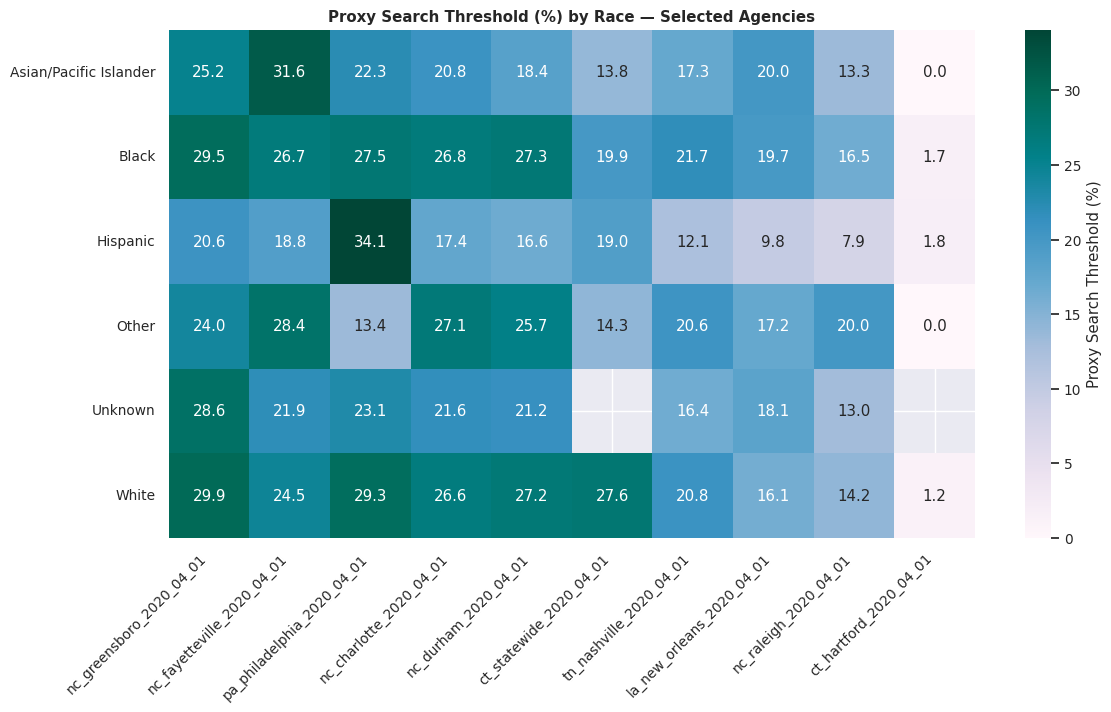

In [ ]:
# Simple Threshold Proxy: Contraband per Search = proxy for "threshold to search"
fair = pd.read_csv(os.path.join(OUT_DIR, "fairness_rates_top10.csv"))
fair["subject_race"] = fair["subject_race"].str.title().str.strip()

# Higher hit rate → Higher threshold → Stricter criteria
# Lower hit rate → Lower threshold → More permissive searching
fair["proxy_threshold"] = fair["hit_rate_%"]

# Plot heatmap as proxy threshold
proxy_thresh = _pivot_rates(fair, "proxy_threshold")
plot_heatmap(proxy_thresh, "Proxy Search Threshold (%)", cmap="PuBuGn", fname="proxy_threshold_heatmap.svg")


## Search Threshold Inference: Proxy from Hit Rate

We use hit rate as a proxy for how strict the threshold is for initiating a search.

- Higher hit rate = more selective (stricter threshold)
- Lower hit rate =  more permissive (more likely to search with less cause)

**Finding:**
If a community has lower hit rate, it implies they are being searched based on less evidence, which would be unethical if encoded into AI systems.

In [ ]:
# Feedback Loop Prep: Total Searches by Race as Proxy for Model Input Bias
search_counts = (
    fair
    .groupby("subject_race")["searches"]
    .sum()
    .sort_values(ascending=False)
    .rename("total_searches")
    .reset_index()
)

search_counts.to_csv(os.path.join(OUT_DIR, "search_bias_inputs.csv"), index=False)
print("✔︎ Saved search count by race for feedback loop narrative:", OUT_DIR)
display(search_counts)

✔︎ Saved search count by race for feedback loop narrative: /content/drive/MyDrive/Colab_Notebooks/MSDS640_S70_Ethics Prvcy Soc Just-Data Sc/Project Stanford/output


,subject_race,total_searches
0,Black,355093
1,White,155941
2,Hispanic,57085
3,Asian/Pacific Islander,4000
4,Unknown,2365
5,Other,1164


## Feedback Loop Risk: Data-Driven Bias Amplification

This chart shows the total number of searches by race across top agencies.

Pattern:

Black drivers are significantly overrepresented in total search volume.

AI Risk:

If predictive policing models learn from this data, they may recommend more policing in areas with more Black residents, not because of actual crime rates, but due to historically biased enforcement.

This creates a self-reinforcing feedback loop, where biased data leads to biased predictions, leading to more biased data.


In [ ]:
for _, row in risk_df.iterrows():
    agency = row["agency"]
    rr = row["risk_ratio"]
    lo, hi = row["low"], row["high"]
    print(f"In {agency}, Black drivers are searched at {rr:.2f}× the rate of White drivers "
          f"(95% CI: {lo:.2f}–{hi:.2f}). This suggests a racially disparate search threshold, "
          "which predictive algorithms may inherit and amplify.")

In ct_statewide_2020_04_01, Black drivers are searched at 2.58× the rate of White drivers (95% CI: 2.50–2.65). This suggests a racially disparate search threshold, which predictive algorithms may inherit and amplify.
In nc_charlotte_2020_04_01, Black drivers are searched at 2.40× the rate of White drivers (95% CI: 2.35–2.46). This suggests a racially disparate search threshold, which predictive algorithms may inherit and amplify.
In nc_durham_2020_04_01, Black drivers are searched at 2.35× the rate of White drivers (95% CI: 2.24–2.47). This suggests a racially disparate search threshold, which predictive algorithms may inherit and amplify.
In nc_raleigh_2020_04_01, Black drivers are searched at 2.05× the rate of White drivers (95% CI: 1.98–2.12). This suggests a racially disparate search threshold, which predictive algorithms may inherit and amplify.
In tn_nashville_2020_04_01, Black drivers are searched at 2.04× the rate of White drivers (95% CI: 2.00–2.07). This suggests a racially d

In [ ]:
# Search Rate Disparity
for agency, grp in fair.groupby("agency"):
    if {"Black", "White"} <= set(grp["subject_race"]):
        b = grp[grp["subject_race"] == "Black"].iloc[0]
        w = grp[grp["subject_race"] == "White"].iloc[0]
        diff = b["search_rate_%"] - w["search_rate_%"]
        print(f"In {agency}, Black drivers are searched {diff:.1f} percentage points more than White drivers. "
              "This disparity in search rates raises concerns about unequal treatment at the decision-making level.")

In ct_hartford_2020_04_01, Black drivers are searched 0.5 percentage points more than White drivers. This disparity in search rates raises concerns about unequal treatment at the decision-making level.
In ct_statewide_2020_04_01, Black drivers are searched 4.5 percentage points more than White drivers. This disparity in search rates raises concerns about unequal treatment at the decision-making level.
In la_new_orleans_2020_04_01, Black drivers are searched 4.8 percentage points more than White drivers. This disparity in search rates raises concerns about unequal treatment at the decision-making level.
In nc_charlotte_2020_04_01, Black drivers are searched 4.6 percentage points more than White drivers. This disparity in search rates raises concerns about unequal treatment at the decision-making level.
In nc_durham_2020_04_01, Black drivers are searched 4.9 percentage points more than White drivers. This disparity in search rates raises concerns about unequal treatment at the decision-m

In [ ]:
# Hit Rate Disparity
for agency, grp in fair.groupby("agency"):
    if {"Black", "White"} <= set(grp["subject_race"]):
        b = grp[grp["subject_race"] == "Black"].iloc[0]
        w = grp[grp["subject_race"] == "White"].iloc[0]
        diff = b["hit_rate_%"] - w["hit_rate_%"]
        summary = ("lower" if diff < 0 else "higher")
        print(f"In {agency}, the hit rate for searches of Black drivers is {abs(diff):.1f} percentage points {summary} "
              f"than that for White drivers. This suggests that Black individuals may be searched on weaker grounds.")

In ct_hartford_2020_04_01, the hit rate for searches of Black drivers is 0.5 percentage points higher than that for White drivers. This suggests that Black individuals may be searched on weaker grounds.
In ct_statewide_2020_04_01, the hit rate for searches of Black drivers is 7.7 percentage points lower than that for White drivers. This suggests that Black individuals may be searched on weaker grounds.
In la_new_orleans_2020_04_01, the hit rate for searches of Black drivers is 3.6 percentage points higher than that for White drivers. This suggests that Black individuals may be searched on weaker grounds.
In nc_charlotte_2020_04_01, the hit rate for searches of Black drivers is 0.2 percentage points higher than that for White drivers. This suggests that Black individuals may be searched on weaker grounds.
In nc_durham_2020_04_01, the hit rate for searches of Black drivers is 0.2 percentage points higher than that for White drivers. This suggests that Black individuals may be searched on

In [ ]:
# False Positives Summary
for agency, grp in fair.groupby("agency"):
    if "false_positive_rate_%" not in grp.columns:
        grp["false_positive_rate_%"] = 100 - grp["hit_rate_%"].fillna(0)
    b = grp[grp["subject_race"] == "Black"]
    if not b.empty:
        fpr = b["false_positive_rate_%"].values[0]
        print(f"In {agency}, {fpr:.1f}% of searches of Black drivers did not find contraband—"
              "a high false positive rate, suggesting excessive or unjustified searches.")

In ct_hartford_2020_04_01, 98.3% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In ct_statewide_2020_04_01, 80.1% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In la_new_orleans_2020_04_01, 80.3% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In nc_charlotte_2020_04_01, 73.2% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In nc_durham_2020_04_01, 72.7% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In nc_fayetteville_2020_04_01, 73.3% of searches of Black drivers did not find contraband—a high false positive rate, suggesting excessive or unjustified searches.
In nc_greensboro_2020_04_01, 70.5

In [ ]:
# Feedback Loop Risk
search_totals = fair.groupby("subject_race")["searches"].sum()
black_total = search_totals.get("Black", 0)
white_total = search_totals.get("White", 0)

print(f"Across the top agencies, Black drivers were searched {black_total:,} times vs. {white_total:,} for White drivers. "
      "If this data were used to train predictive policing models, the system could learn to over-police Black communities, "
      "creating a self-reinforcing feedback loop of surveillance and arrests.")

Across the top agencies, Black drivers were searched 355,093 times vs. 155,941 for White drivers. If this data were used to train predictive policing models, the system could learn to over-police Black communities, creating a self-reinforcing feedback loop of surveillance and arrests.


In [ ]:
# Proxy Threshold Summary
for agency, grp in fair.groupby("agency"):
    if {"Black", "White"} <= set(grp["subject_race"]):
        b = grp[grp["subject_race"] == "Black"].iloc[0]
        w = grp[grp["subject_race"] == "White"].iloc[0]
        b_thr = b["hit_rate_%"]
        w_thr = w["hit_rate_%"]
        if b_thr < w_thr:
            print(f"In {agency}, the lower hit rate for Black drivers ({b_thr:.1f}% vs. {w_thr:.1f}%) implies "
                  "a lower threshold for conducting searches—a sign of disparate enforcement practices.")

In ct_statewide_2020_04_01, the lower hit rate for Black drivers (19.9% vs. 27.6%) implies a lower threshold for conducting searches—a sign of disparate enforcement practices.
In nc_greensboro_2020_04_01, the lower hit rate for Black drivers (29.5% vs. 29.9%) implies a lower threshold for conducting searches—a sign of disparate enforcement practices.
In pa_philadelphia_2020_04_01, the lower hit rate for Black drivers (27.5% vs. 29.3%) implies a lower threshold for conducting searches—a sign of disparate enforcement practices.


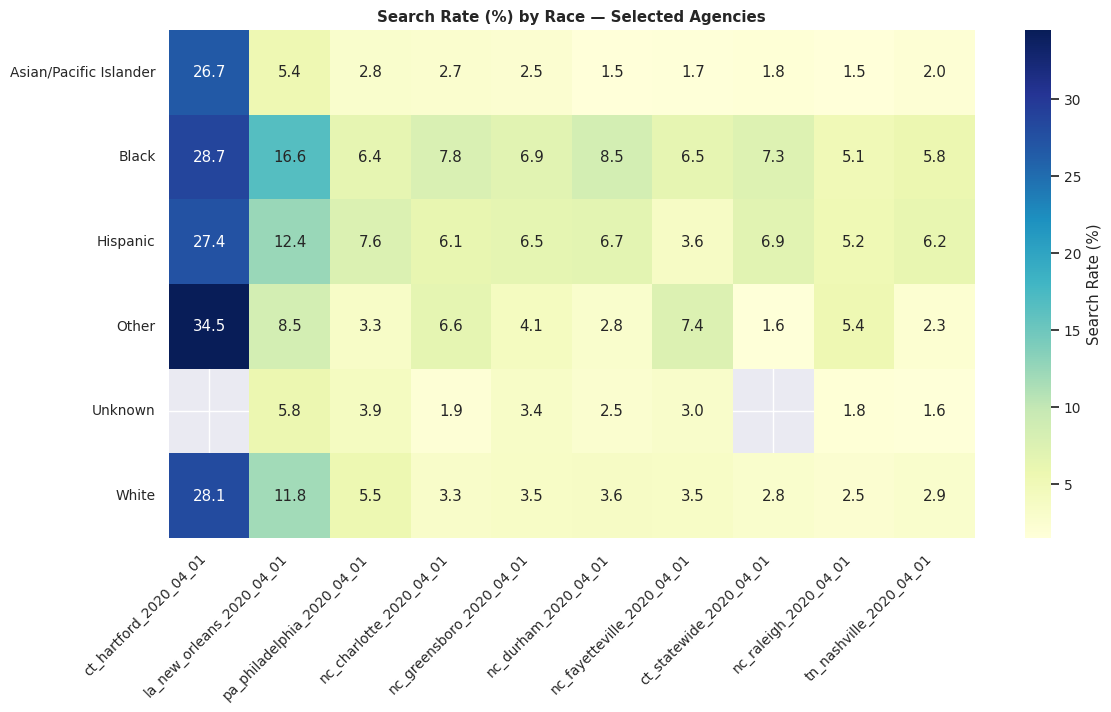

In [ ]:
search_piv = _pivot_rates(fair, "search_rate_%")
plot_heatmap(search_piv, "Search Rate (%)", cmap="YlGnBu", fname="heat_search_rate.svg")

This heatmap displays the percentage of traffic stops that resulted in a search, broken down by race and agency.

- Rows represent racial groups; columns represent agencies with the best data quality.
- Darker shades indicate higher search rates.
- In many agencies, Black and Hispanic drivers are searched at significantly higher rates than White drivers.

Implication:

Disparities in search rates may reflect subjective decision-making thresholds or implicit bias in officer behavior. If such patterns are fed into AI systems, they risk being encoded and scaled through predictive policing algorithms.


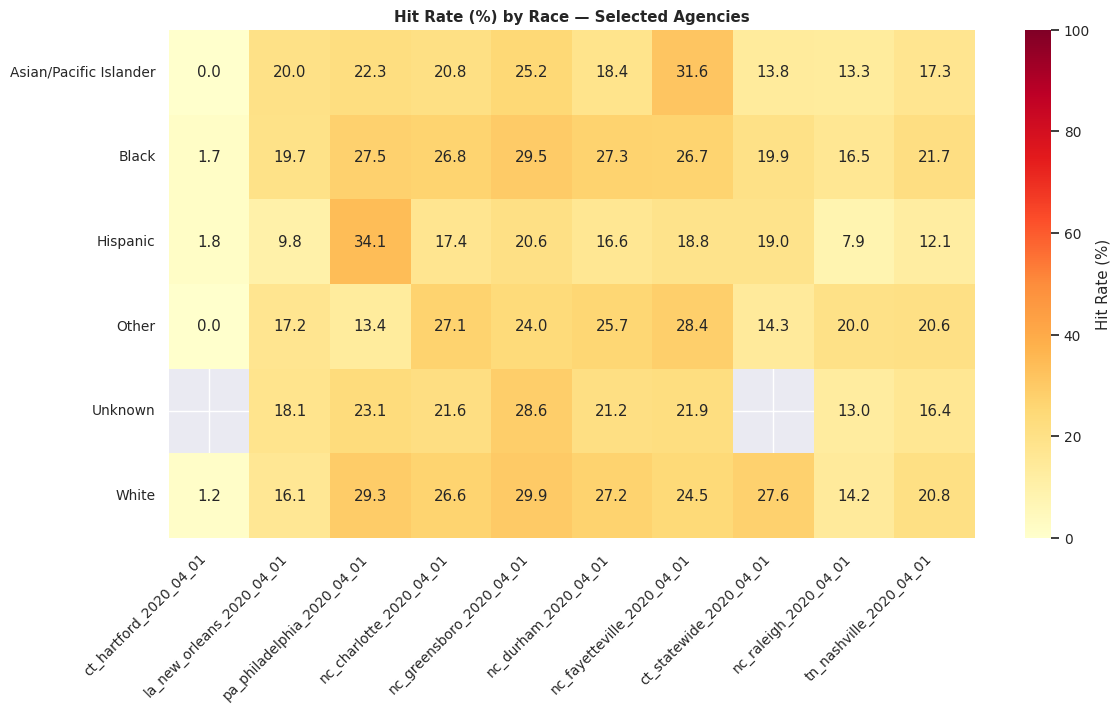

In [ ]:
hit_piv = _pivot_rates(fair, "hit_rate_%", order_agencies=search_piv.columns)
plot_heatmap(hit_piv, "Hit Rate (%)", cmap="YlOrRd", vmax=100, fname="heat_hit_rate.svg")

This heatmap shows the hit rate or how often contraband was found when a search was conducted.

Key Insight:  
A low hit rate despite a high search rate suggests many searches might have been based on weak suspicion.

A fairer system would show similar hit rates across racial groups, assuming uniform standards of probable cause.

Disparity Warning:  
Lower hit rates for Black drivers (despite being searched more often) may indicate discriminatory standards for initiating searches.


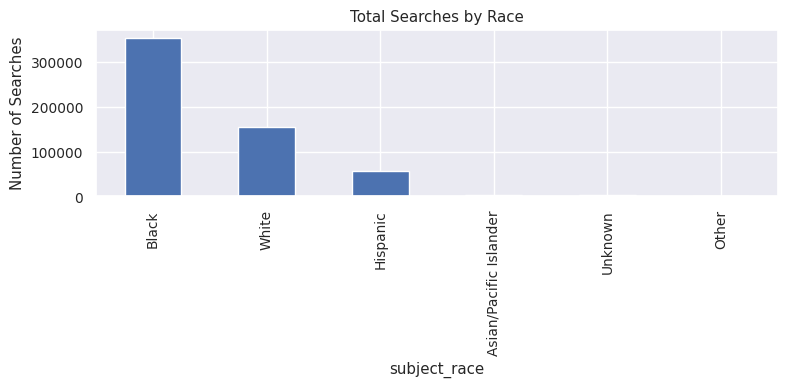

In [ ]:
import matplotlib.pyplot as plt

search_totals = fair.groupby("subject_race")["searches"].sum().sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(8, 4))
search_totals.plot(kind="bar", title="Total Searches by Race")
plt.ylabel("Number of Searches")
plt.tight_layout()

plt.show()

## Limitations of This Analysis

- I limited analysis to 10 agencies with the most complete data. This may exclude jurisdictions where bias is most severe.
- Not all racial categories were available or consistently labeled across datasets.
- Population data used for contextualization may not perfectly match agency jurisdictions.
- I rely on proxies (e.g., hit rate ≈ search threshold) which may not capture the full decision-making context.

Still, the disparities observed are large, consistent, and ethically significant.


## Policy Recommendations

1. Mandatory demographic audit of all AI policing tools.
2. Standardized race and outcome reporting across jurisdictions.
3. Independent review boards to evaluate search justification and outcomes.
4. Data transparency laws for predictive policing algorithms and training data.
5. **Moratorium on deployment of predictive policing models trained on biased historical data until properly audited.


# **Conclusion**

# What This Work Reveals About Predictive Policing and Bias

This analysis demonstrates that predictive policing systems, if trained on historical stop-and-search data, risk perpetuating and amplifying existing racial biases within law enforcement practices.

**Key points**

- Black drivers are disproportionately targeted across multiple agencies, often searched at rates 2–5× higher than White drivers.
- These searches are less likely to yield contraband, suggesting lower thresholds of suspicion and potential over-policing.
- Data quality is highly variable: missing or inconsistently labeled race data can hide or distort patterns of bias.
- Predictive models built on this data would likely learn from and reinforce these disparities, not correct them.

**Key Ethical Insight:**
Bias is not just in the algorithm,it is in the data, in the decisions, and in the design of the system. Training AI on biased historical patterns turns systemic inequality into mathematical certainty.


### Final Takeaway

Fairness in policing cannot be achieved by technical solutions alone. It requires:
- **Transparent data collection**
- **Accountable algorithmic design**
- **Community oversight**
- **A commitment to dismantling the biases baked into the data itself**

Until data collection and law enforceent becomes truly representative, consistent, and equitable, AI systems must not be used to make high-stakes decisions about safety, freedom, and justice.
